In [4]:
import os
import rasterio
import pandas as pd
import zipfile

# --- CONFIGURATION ---
inegi_path = "../data/raw/inegi_cem/Colima_r15m.tif"
conafor_path = "../data/raw/conafor_infys/INFyS_2015_2020_Colima_qM0XXKR.xlsx"
sentinel_dir = "../data/raw/sentinel/"

# --- VERIFICATION ---
print("--- STARTING DATA AUDIT ---")

# 1. INEGI
if os.path.exists(inegi_path):
    try:
        with rasterio.open(inegi_path) as src:
            print(f"✅ INEGI Elevation: LOADED (Resolution: {src.res[0]}m)")
    except Exception as e:
        print(f"❌ INEGI Error: {e}")
else:
    print(f"❌ INEGI Not Found: {inegi_path}")

# 2. CONAFOR
if os.path.exists(conafor_path):
    try:
        df = pd.read_excel(conafor_path)
        print(f"✅ CONAFOR Data: LOADED ({len(df)} sites)")
    except Exception as e:
        print(f"❌ CONAFOR Error: {e}")
else:
    print(f"❌ CONAFOR Not Found: {conafor_path}")

# 3. SENTINEL
try:
    zips = [f for f in os.listdir(sentinel_dir) if f.endswith('.zip')]
    if zips:
        print(f"✅ Sentinel Zip Found: {zips[0]}")
    else:
        print("❌ No Sentinel .zip found!")
except Exception as e:
    print(f"❌ Sentinel Error: {e}")

--- STARTING DATA AUDIT ---
✅ INEGI Elevation: LOADED (Resolution: 0.00013888888900000034m)
✅ CONAFOR Data: LOADED (74 sites)
✅ Sentinel Zip Found: S2B_MSIL2A_20240501T171859_N0510_R012_T13QEB_20240501T214403.SAFE.zip


In [3]:
!pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]



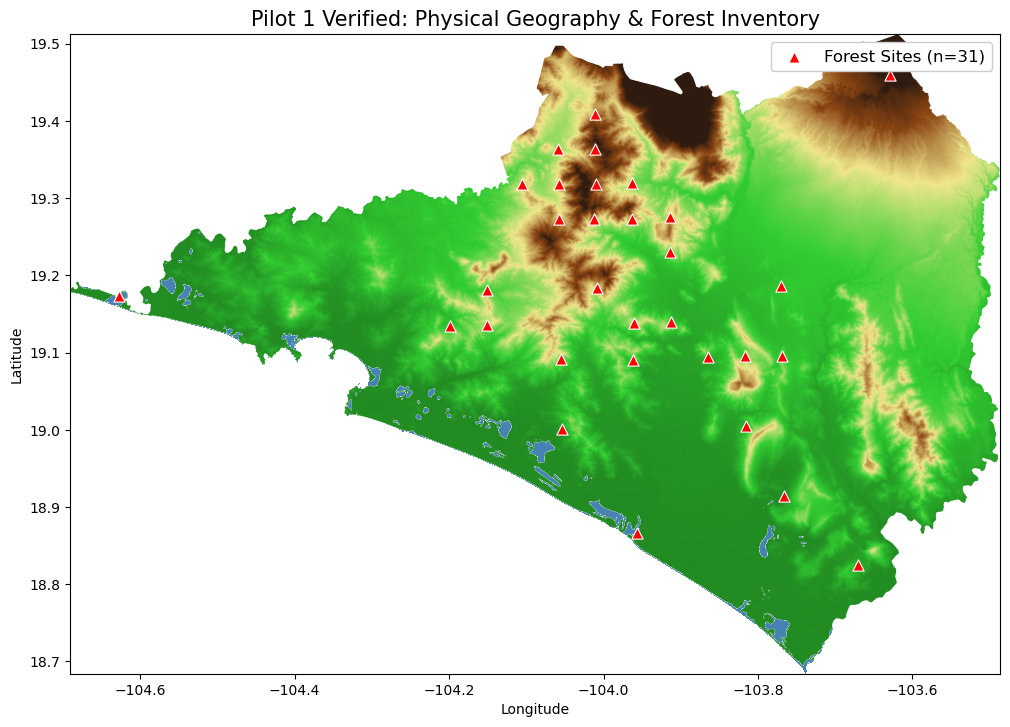

In [16]:
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize, ListedColormap

# --- CONFIGURATION ---
inegi_path = "../data/raw/inegi_cem/Colima_r15m.tif"
conafor_path = "../data/raw/conafor_infys/INFyS_2015_2020_Colima_qM0XXKR.xlsx"

# 1. LOAD DATA
with rasterio.open(inegi_path) as dem:
    raw_data = dem.read(1)
    extent = [dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top]
    
    # 2. CREATE TWO LAYERS
    
    # LAYER A: WATER (Values <= 0)
    # We mask everything that IS land, leaving only the water.
    water_layer = np.ma.masked_greater(raw_data, 0)
    
    # LAYER B: LAND (Values > 0)
    # We mask everything that IS water (and huge errors), leaving only land.
    land_data = np.where(raw_data < 0, 0, raw_data) # Fix negative sinks first
    land_layer = np.ma.masked_less_equal(land_data, 0)
    land_layer = np.ma.masked_greater(land_layer, 5000) # Mask errors

# 3. DEFINE CUSTOM COLORS (The "Google Maps" Look)

# A. Land Palette: Deep Green -> Yellow/Tan -> Dark Brown -> Black
# We define the colors explicitly so there is NO chance of blue/white appearing.
land_colors = ["#228B22", "#32CD32", "#F0E68C", "#8B4513", "#2F1B10"]
# Positions:   Forest     Light Green  Sand/Tan   Brown      Dark Peak
land_cmap = LinearSegmentedColormap.from_list("CustomLand", land_colors)
land_cmap.set_bad(color='white', alpha=0) # Make "empty" space transparent

# B. Water Palette: Just one solid blue color
water_cmap = ListedColormap(["#4682B4"]) # Steel Blue
water_cmap.set_bad(color='white', alpha=0) # Transparent if not water

# 4. LOAD FOREST DATA
df = pd.read_excel(conafor_path)
cols = df.columns.str.upper()
if 'Y_C3' in df.columns: lat_col, lon_col = 'Y_C3', 'X_C3'
else: lat_col, lon_col = 'Latitud', 'Longitud'
df = df.dropna(subset=[lat_col, lon_col])
df.loc[df[lat_col] > 100, lat_col] /= 1000000.0
df.loc[df[lon_col] < -200, lon_col] /= 1000000.0
bounds = dem.bounds
mask_inside = (df[lon_col] >= bounds.left) & (df[lon_col] <= bounds.right) & \
              (df[lat_col] >= bounds.bottom) & (df[lat_col] <= bounds.top)
df_clean = df[mask_inside]

# 5. PLOT LAYERS
fig, ax = plt.subplots(figsize=(12, 12))

# Step 1: Paint the Background White (Removes the "Black Frame")
ax.set_facecolor('white')

# Step 2: Plot the WATER Layer
# We use vmin/vmax to ensure the single color is applied flatly
ax.imshow(water_layer, cmap=water_cmap, extent=extent, origin='upper', interpolation='nearest')

# Step 3: Plot the LAND Layer on top
# We stretch the contrast so the Dark Brown hits the 98th percentile
vmax_land = np.percentile(land_layer.compressed(), 98)
ax.imshow(land_layer, cmap=land_cmap, extent=extent, origin='upper', 
          vmin=0, vmax=vmax_land)

# Step 4: Plot the Sites
site_count = len(df_clean)
ax.scatter(df_clean[lon_col], df_clean[lat_col], 
           c='red', s=65, marker='^', 
           label=f'Forest Sites (n={site_count})', 
           edgecolor='white', linewidth=0.8)

# Final Polish
ax.set_title(f"Pilot 1 Verified: Physical Geography & Forest Inventory", fontsize=15)
ax.legend(loc='upper right', frameon=True, facecolor='white', framealpha=1, fontsize=12)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(False) # Keep grid off for clean look

plt.show()